In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import umap
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Load dataset
rootpath = "../KuaiRec 2.0/"
small_matrix = pd.read_csv(rootpath + "data/small_matrix.csv")
print(f"Before dropping na values: {len(small_matrix)}")
small_matrix = small_matrix.dropna()
print(f"After dropping na values: {len(small_matrix)}")

Before dropping na: 4676570
After dropping na: 4494578


# User Segmentation

## Temporal Features

### Hour, Day of Week & Date

In [16]:
small_matrix['time'] = pd.to_datetime(small_matrix['time'])

In [24]:
small_matrix['hour'] = small_matrix['time'].dt.hour
small_matrix['day_of_week'] = small_matrix['time'].dt.dayofweek
small_matrix['date'] = small_matrix['time'].dt.date

### Weekends & Day/Night

In [18]:
small_matrix['is_weekend'] = small_matrix['day_of_week'].isin([5, 6]).astype(int)
small_matrix['time_bin'] = pd.cut(small_matrix['hour'], 
                                  bins=[0, 6, 12, 18, 24], 
                                  labels=['Midnight', 'Morning', 'Afternoon', 'Evening'])

### Average watch time (per day)

In [20]:
daily_watch_time = small_matrix.groupby(['user_id', 'date'])['play_duration'].sum().reset_index()
avg_daily_watch_time = daily_watch_time.groupby('user_id')['play_duration'].mean().reset_index()
avg_daily_watch_time.columns = ['user_id', 'avg_daily_watch_time']

### Watch Frequency

In [22]:
# also average number of videos viewed per day
small_matrix['days_since_first_watch'] = (small_matrix['time'].max() - small_matrix.groupby('user_id')['time'].transform('min')).dt.days
small_matrix['watch_frequency'] = small_matrix.groupby('user_id')['user_id'].transform('count') / (small_matrix['days_since_first_watch'] + 1)

### Aggregating user features

In [44]:
# aggregate watch frequency and is_weekend
user_features = small_matrix.groupby('user_id').agg({
    'is_weekend': 'mean',
    'watch_frequency': 'mean',
}).reset_index()

# add in counts of time bins
time_bin_counts = small_matrix.groupby('user_id')['time_bin'].value_counts().unstack(fill_value=0)
time_bin_counts.columns = [f'count_{col.lower()}_views' for col in time_bin_counts.columns]
user_features = user_features.merge(time_bin_counts, on='user_id', how='outer')

# add in average watch time (per day)
user_features = user_features.merge(avg_daily_watch_time, on='user_id', how='outer')

### Merging with other user features

In [47]:
users = pd.read_csv(rootpath + "data/user_features.csv")

In [50]:
users_subset = users[['user_id', 'user_active_degree', 'friend_user_num', 'follow_user_num']]
user_features = user_features.merge(users_subset, on='user_id', how='left')

In [51]:
user_features.head()

,user_id,is_weekend,watch_frequency,count_night_views,count_morning_views,count_afternoon_views,count_evening_views,avg_daily_watch_time,user_active_degree,friend_user_num,follow_user_num
0,14,0.247372,51.333333,1462,331,358,818,494038.968254,full_active,1,73
1,19,0.287855,50.841270,3,1774,1425,1,402150.539683,full_active,1,3
2,21,0.308145,51.253968,666,967,1109,442,459509.349206,high_active,0,63
3,23,0.263041,50.206349,218,1174,1321,447,518617.377049,full_active,0,94
4,24,0.267212,50.492063,227,1276,1118,443,421845.500000,full_active,0,59


## User Segmentation

In [62]:
numerical_features = [
    'is_weekend', 'watch_frequency', 'count_night_views', 'count_morning_views',
    'count_afternoon_views', 'count_evening_views', 'avg_daily_watch_time',
    'friend_user_num', 'follow_user_num'
]

# ordinal features
ordinal_features = ['user_active_degree']
user_active_degree_categories = ['UNKNOWN', 'middle_active', 'full_active', 'high_active']

X_numerical = user_features[numerical_features]
X_ordinal = user_features[ordinal_features]

# scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# encode ordinal features
ordinal_encoder = OrdinalEncoder(categories=[user_active_degree_categories])
X_ordinal_encoded = ordinal_encoder.fit_transform(X_ordinal)

# combine features
X_preprocessed = np.hstack((X_numerical_scaled, X_ordinal_encoded))

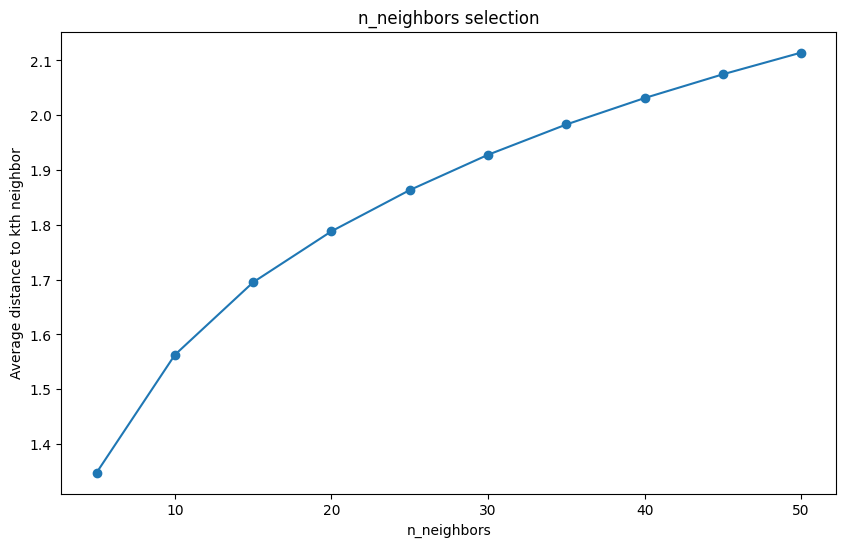

In [67]:
from sklearn.neighbors import NearestNeighbors

def compute_nearest_neighbor_distances(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)
    return distances[:, -1]

k_values = list(range(5, 51, 5))
avg_distances = [np.mean(compute_nearest_neighbor_distances(X_preprocessed, k)) for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_distances, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Average distance to kth neighbor')
plt.title('n_neighbors selection')
plt.show()

In [69]:
umap.Umap

AttributeError: module 'umap' has no attribute 'Umap'

In [68]:
n_neighbors = 15  # Choose based on the plot above
min_dist = 0.1  # We'll tune this later

max_components = min(X_preprocessed.shape[1], 20)  # Up to original dimensionality or 20, whichever is smaller
n_components_range = range(2, max_components + 1)

reconstruction_errors = []
clustering_scores = []

for n_components in n_components_range:
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist, random_state=42)
    embedding = umap_reducer.fit_transform(X_preprocessed)
    
    # Compute reconstruction error
    reconstruction = umap_reducer.inverse_transform(embedding)
    error = np.mean(np.sum((X_preprocessed - reconstruction) ** 2, axis=1))
    reconstruction_errors.append(error)
    
    # Compute clustering quality (using HDBSCAN and silhouette score)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)
    cluster_labels = clusterer.fit_predict(embedding)
    if len(np.unique(cluster_labels)) > 1:  # Silhouette score needs at least 2 clusters
        score = silhouette_score(embedding, cluster_labels)
    else:
        score = -1  # Assign a low score if only one cluster is found
    clustering_scores.append(score)

AttributeError: module 'umap' has no attribute 'UMAP'